In [36]:
!jupyter nbconvert --to markdown 6_2_5_Exercises.ipynb

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook 6_2_5_Exercises.ipynb to markdown
[NbConvertApp] Support files will be in 6_2_5_Exercises_files/
[NbConvertApp] Making directory 6_2_5_Exercises_files
[NbConvertApp] Writing 5824 bytes to 6_2_5_Exercises.md


# 1. What kinds of problems will occur if you change MySequential to store modules in a Python list?

If you change `MySequential` to store modules in a Python list instead of using the `nn.Sequential` container, you might get `ValueError: optimizer got an empty parameter list` error, because the `nn.Sequential` container automatically tracks and registers the parameters of each module added to it. If you use a Python list, you'll need to manually manage parameter registration, which can lead to errors if not done correctly.

In [23]:
import torch.nn as nn
import torch
import sys
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
import warnings
warnings.filterwarnings("ignore")

class MySequential(d2l.Module):
    def __init__(self, *args):
        super().__init__()
        self.modules = []
        for idx, module in enumerate(args):
            self.modules.append(module)
            
    def forward(self, X):
        for module in self.modules:
            X = module(X)
        return X
    
class MySequentialMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        layers = [nn.Flatten()]
        for num in num_hiddens:
            layers.append(nn.LazyLinear(num))
            layers.append(nn.ReLU())
        layers.append(nn.LazyLinear(num_outputs))
        self.net = MySequential(*layers)

(86.71588633954525, 16.023116797208786)

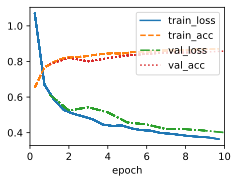

In [21]:
hparams = {'num_hiddens':[256],'num_outputs':10,'lr':0.1}
model = d2l.MulMLP(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [24]:
model = MySequentialMLP(**hparams)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

ValueError: optimizer got an empty parameter list

# 2. Implement a module that takes two modules as an argument, say net1 and net2 and returns the concatenated output of both networks in the forward propagation. This is also called a parallel module.

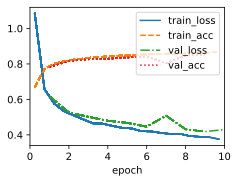

In [ ]:
class ConcatLayer(d2l.Classifier, d2l.HyperParameters):
    def __init__(self, net1, net2, lr):
        super().__init__()
        self.save_hyperparameters()
        
    def forward(self, X):
        X1 = self.net1(X)
        X2 = self.net2(X)
        return torch.cat((X1,X2),dim=-1)

hparams1 = {'num_hiddens':[256],'num_outputs':5,'lr':0.1}
hparams2 = {'num_hiddens':[256],'num_outputs':5,'lr':0.1}
model = ConcatLayer(d2l.MulMLP(**hparams1),d2l.MulMLP(**hparams2),lr=0.1)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

# 3. Assume that you want to concatenate multiple instances of the same network. Implement a factory function that generates multiple instances of the same module and build a larger network from it.

In [ ]:
class ConcatMulMLP(d2l.MulMLP):
    def __init__(self, num_outputs, num_hiddens, lr, concats):
        super().__init__(num_outputs, num_hiddens, lr)
        self.save_hyperparameters()
        
    def forward(self, X):
        return torch.cat([self.net[:i+1](X) for i in self.concats],dim=-1)
    
hparams = {'num_hiddens':[16,8,2],'num_outputs':5,'lr':0.1,'concats':[1,2]}
model = ConcatMulMLP(**hparams)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)